In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import esda
import libpysal as lps

import warnings
warnings.filterwarnings("ignore")

import os
GEODATA_PATH = 'data/geodata/'

## Barangays GeoData

In [2]:
brgys_geodata = gpd.read_file(GEODATA_PATH+'AdministrativeBoundariesBARMMBarangays20190206PSA2016/AdministrativeBoundariesBARMMBarangays20190206PSA2016.shp')
cond = brgys_geodata['Reg_Code']=='PH150000000'
brgys_geodata=brgys_geodata[cond].reset_index(drop=True)
brgys_geodata.head()

,Reg_Code,Reg_Name,Pro_Code,Pro_Name,Mun_Code,Mun_Name,Bgy_Code,Bgy_Name,geometry
0,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),PH157001001,Balimbing Proper,"MULTIPOLYGON (((162191.469 562138.624, 162202...."
1,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),PH157001002,Batu-batu (Pob.),"POLYGON ((154788.744 561141.297, 154788.577 56..."
2,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),PH157001003,Buan,"MULTIPOLYGON (((174430.408 571246.155, 174433...."
3,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),PH157001004,Dungon,"POLYGON ((182461.829 575050.555, 182461.151 57..."
4,PH150000000,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),PH157000000,TAWI-TAWI,PH157001000,PANGLIMA SUGALA (BALIMBING),PH157001005,Luuk Buntal,"MULTIPOLYGON (((165920.073 551841.163, 165917...."


In [3]:
brgys_geodata.crs.geodetic_crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
brgys_geodata = brgys_geodata.to_crs("EPSG:4326")
brgys_geodata.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

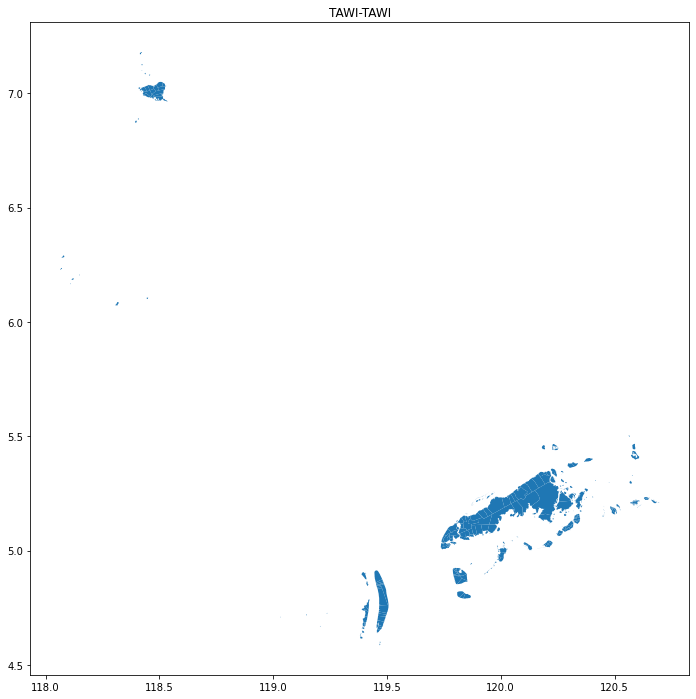

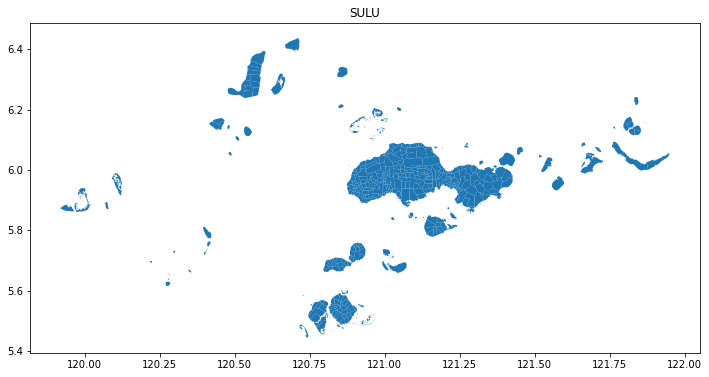

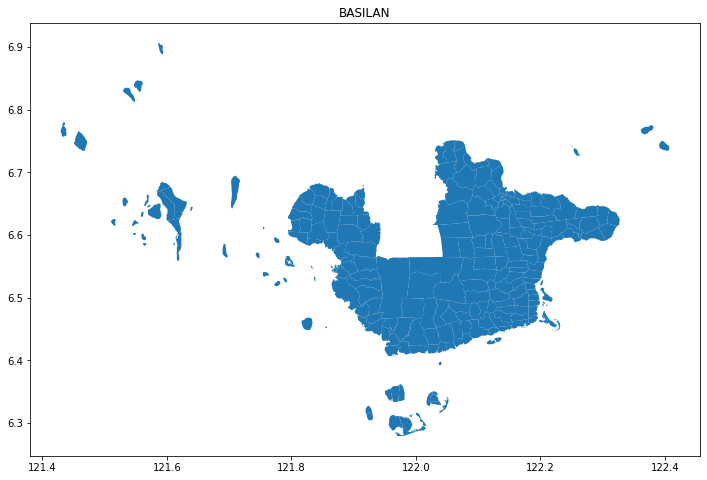

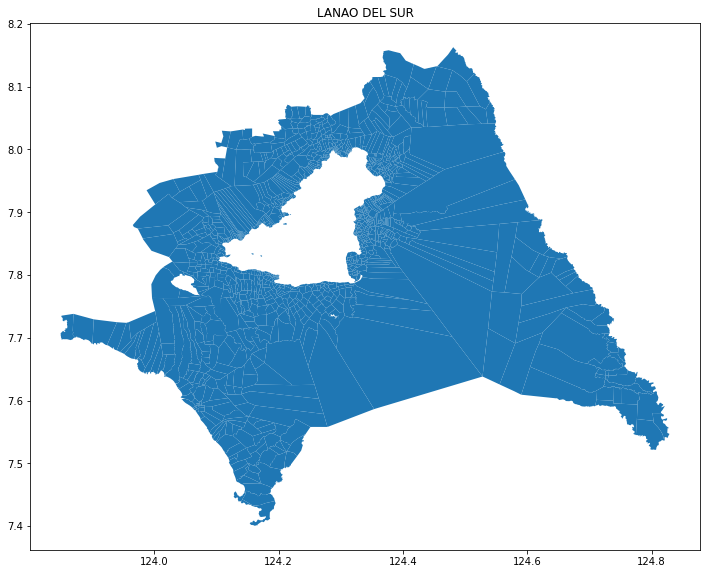

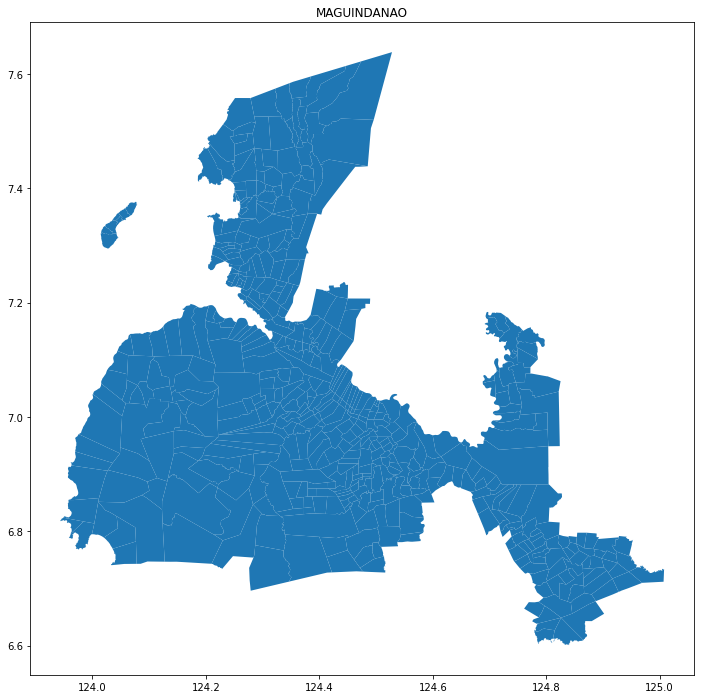

In [5]:
for province in brgys_geodata['Pro_Name'].unique():
    cond = brgys_geodata['Pro_Name']==province
    brgys_geodata[cond].plot(figsize=(12, 12))
    plt.title(province)
    plt.show()

## Schools GeoData

In [6]:
schools_geodata = gpd.read_file(GEODATA_PATH+'SchoolsARMMDEPED2017/SchoolsARMMDEPED2017.shp')
schools_geodata["SCH_TYPE"] = schools_geodata["SCH_TYPE"].replace({'PUBLIC':'Public'})
schools_geodata.head()

,SCH_ID,SCH_NAME,SCH_CAT,SCH_TYPE,LAT,LONG,BARANGAY,MUNNAME,PROV,PSGC_MUNI,PSGC_BRGY,PSGC_PROV,geometry
0,133049,Abong-Abong ES,ES,Public,6.507703,121.910937,Abong-Abong,Maluso,BASILAN,PH150704000,PH150704001,PH150700000,POINT (121.91094 6.50770)
1,215015,Akbar ES,ES,Public,6.664125,122.195725,Upper Bato-Bato,Akbar,BASILAN,PH150708000,PH150708008,PH150700000,POINT (122.19572 6.66413)
2,133154,Amaloy ES,ES,Public,6.443614,122.126717,Amaloy,Ungkaya Pukan,BASILAN,PH150711000,PH150711001,PH150700000,POINT (122.12672 6.44361)
3,133023,Atong-Atong ES,ES,Public,6.660000,121.899633,Atong-Atong,Lantawan,BASILAN,PH150703000,PH150703001,PH150700000,POINT (121.89963 6.66000)
4,133081,Babag ES,ES,Public,6.342007,121.954045,Babag (Babuan Island),Tabuan-Lasa,BASILAN,PH150713000,PH150713001,PH150700000,POINT (121.95404 6.34201)


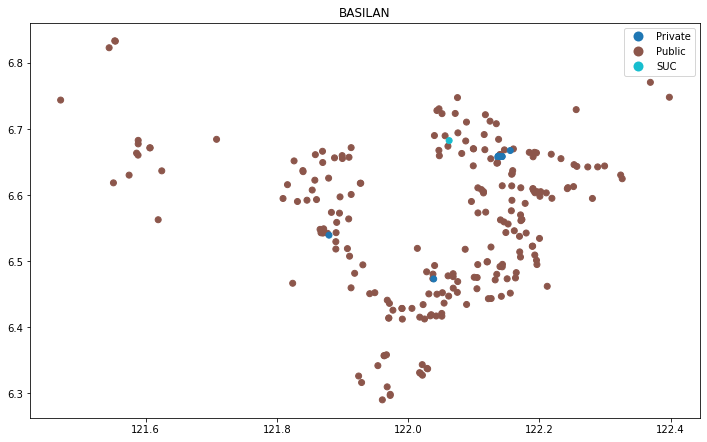

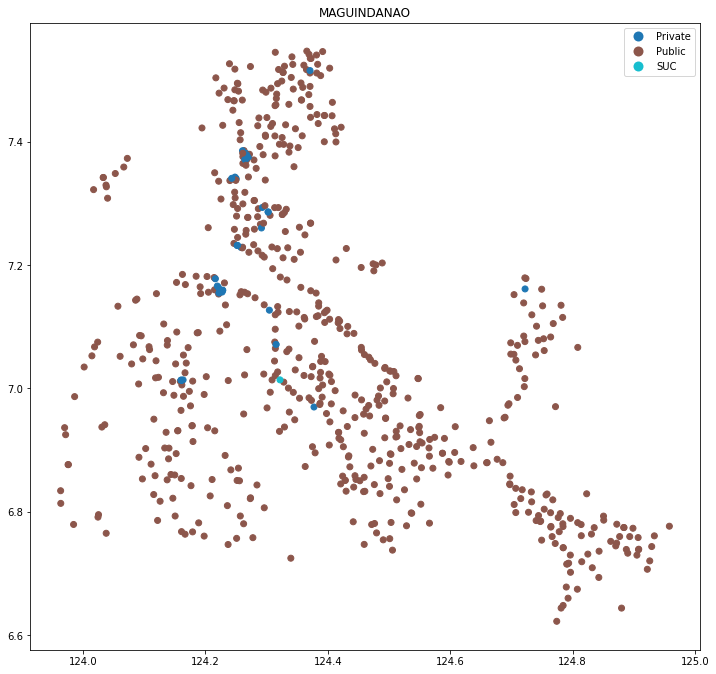

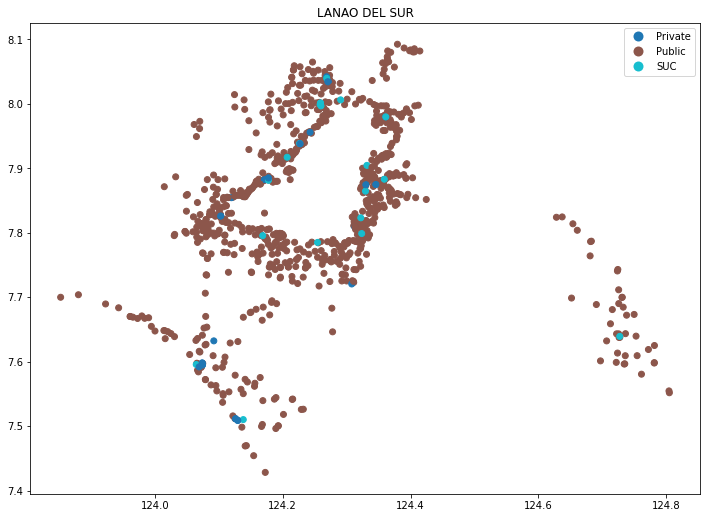

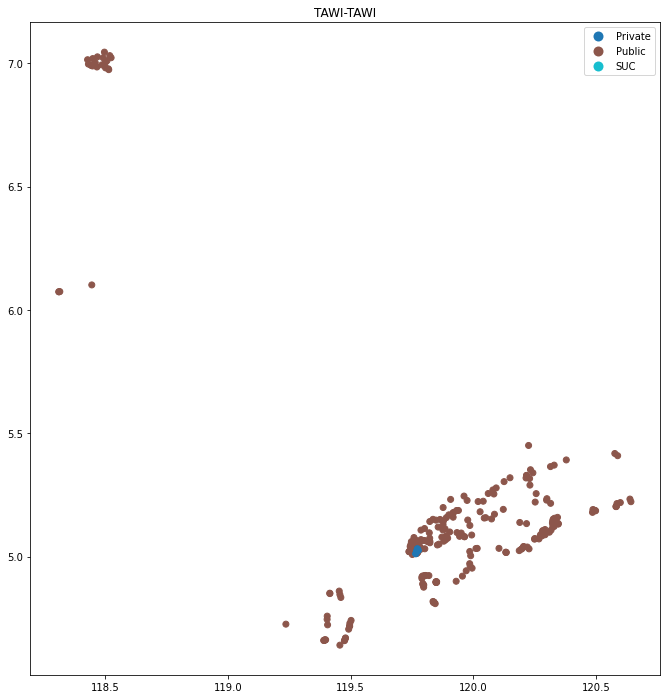

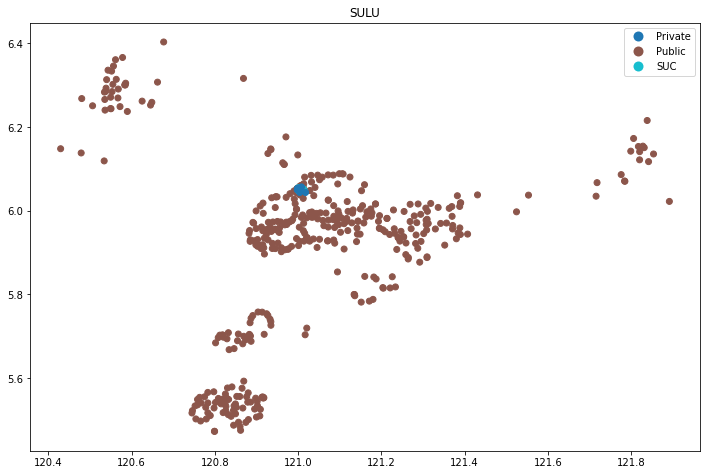

In [7]:
for province in schools_geodata['PROV'].unique():
    cond = schools_geodata['PROV']==province
    schools_geodata[cond].dropna()\
                         .plot(column="SCH_TYPE",figsize=(12, 12),legend=True)
    plt.title(province)
    plt.show()

## Roads GeoData

In [8]:
roads_geodata = gpd.read_file(GEODATA_PATH+'InfraRoadsARMMOSM2019/InfraRoadsARMMOSM2019.shp')
roads_geodata.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,210935215,5113,primary,None,None,B,0,0,F,F,"LINESTRING (122.27089 6.64083, 122.27119 6.640..."
1,210935219,5113,primary,None,None,B,0,0,F,F,"LINESTRING (122.11945 6.50060, 122.11907 6.501..."
2,210935220,5142,track,None,None,B,0,0,F,F,"LINESTRING (122.14195 6.63450, 122.14231 6.634..."
3,210935221,5142,track,None,None,B,0,0,F,F,"LINESTRING (122.16074 6.63023, 122.16049 6.629..."
4,210935223,5142,track,None,None,B,0,0,F,F,"LINESTRING (122.22433 6.65494, 122.22405 6.655..."


In [9]:
roads_geodata["fclass"].value_counts()

residential       3055
unclassified       883
track              808
tertiary           595
service            438
primary            228
trunk              168
secondary          150
path                89
footway             73
unknown             25
tertiary_link       20
steps               10
trunk_link           8
cycleway             7
pedestrian           6
primary_link         6
secondary_link       3
bridleway            1
Name: fclass, dtype: int64

Check if we have roads passing atleast 2 province

In [10]:
roads_geodata["PROV"] = None

no_intersection = []

for i in range(len(roads_geodata)):
    check = brgys_geodata['geometry'].intersects(roads_geodata.loc[i,'geometry'])
    prov_check = len(brgys_geodata.loc[check,'Pro_Name'].unique())
    if prov_check>1:
        print(i,sum(check),prov_check)
        print(brgys_geodata.loc[check,'Pro_Name'].value_counts())
        
        # get majority province
        roads_geodata.loc[i,"PROV"] = brgys_geodata.loc[check,'Pro_Name'].value_counts().index[0]
        continue
    if prov_check==1:
        roads_geodata.loc[i,"PROV"] = brgys_geodata.loc[check,'Pro_Name'].unique()[0]
    else:
        no_intersection.append(i)
        
print(len(no_intersection))

557 6 2
LANAO DEL SUR    5
MAGUINDANAO      1
Name: Pro_Name, dtype: int64
4947 2 2
MAGUINDANAO      1
LANAO DEL SUR    1
Name: Pro_Name, dtype: int64
2328


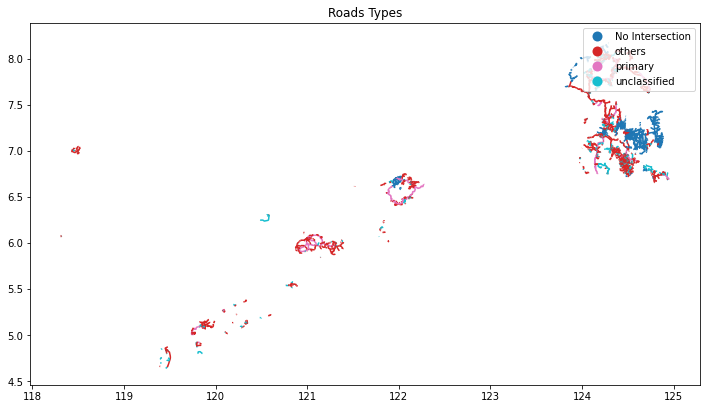

In [11]:
roads_geodata["road_types"] = "others"

cond = roads_geodata["fclass"]=="primary"
roads_geodata.loc[cond,"road_types"] = "primary"

cond = roads_geodata["fclass"]=="unclassified"
roads_geodata.loc[cond,"road_types"] = "unclassified"

roads_geodata.loc[no_intersection,'road_types']="No Intersection"

f, ax = plt.subplots(1, figsize=(12, 12))
ax = roads_geodata.plot(column="road_types", ax=ax,legend=True)
plt.title("Roads Types")
plt.show()

No Intersection    2328
MAGUINDANAO        1876
LANAO DEL SUR      1123
SULU                646
TAWI-TAWI           328
BASILAN             272
Name: PROV, dtype: int64


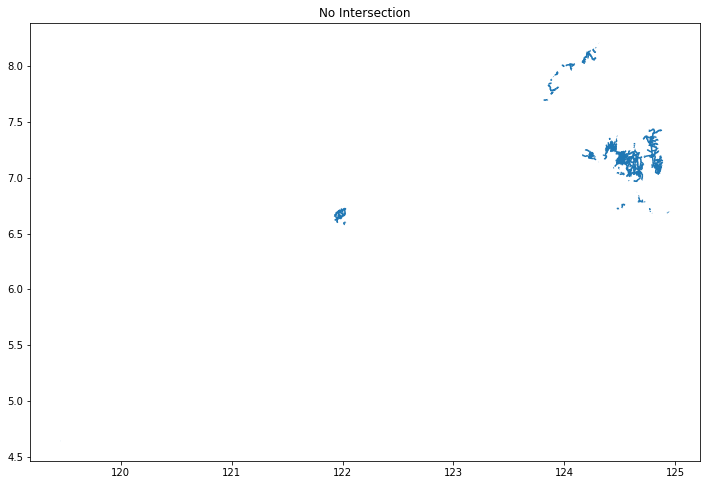

In [12]:
roads_geodata.loc[no_intersection,'PROV']="No Intersection"

print(roads_geodata["PROV"].value_counts())

cond = roads_geodata['PROV']=="No Intersection"
f, ax = plt.subplots(1, figsize=(12, 12))
ax = roads_geodata[cond].plot(column="PROV", ax=ax)
plt.title("No Intersection")
plt.show()

MAGUINDANAO      1876
LANAO DEL SUR    1123
SULU              646
TAWI-TAWI         328
BASILAN           272
Name: PROV, dtype: int64


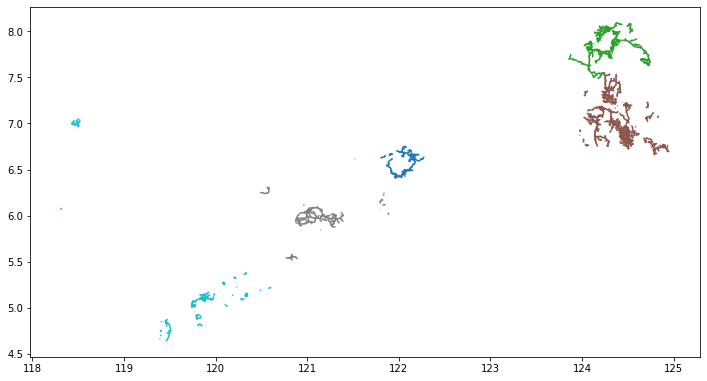

In [13]:
cond = roads_geodata["PROV"]!='No Intersection'
roads_geodata = roads_geodata[cond]

print(roads_geodata["PROV"].value_counts())

f, ax = plt.subplots(1, figsize=(12, 12))
roads_geodata.plot(column="PROV", ax=ax)
plt.show()

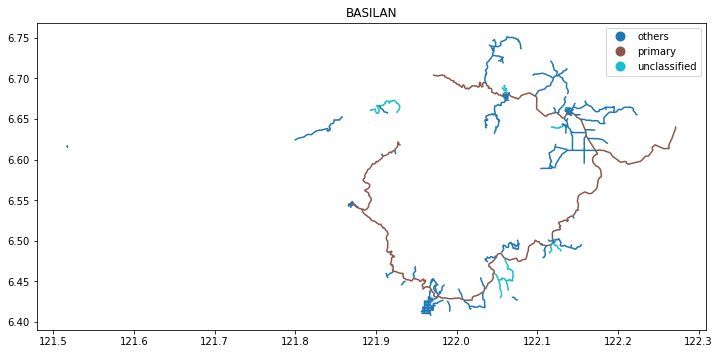

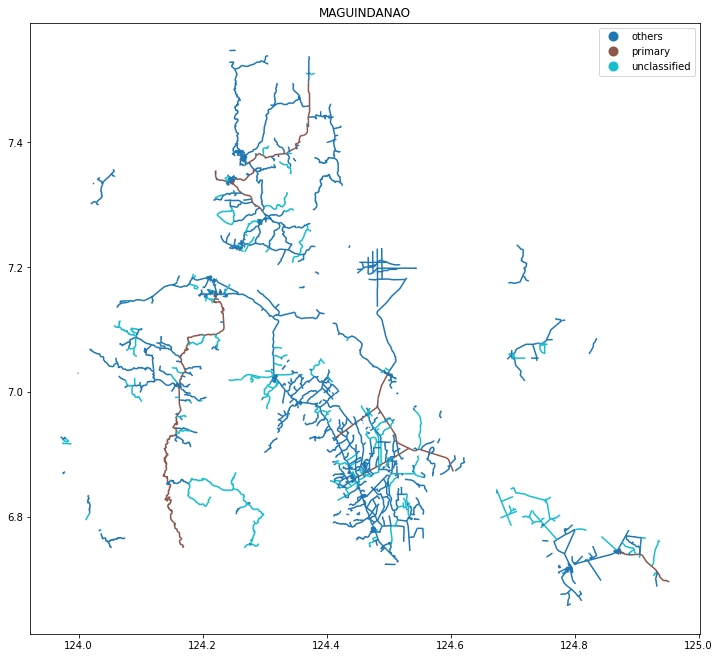

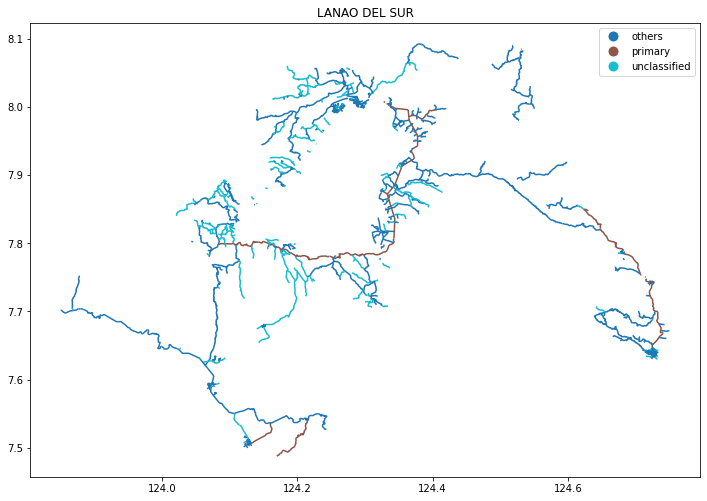

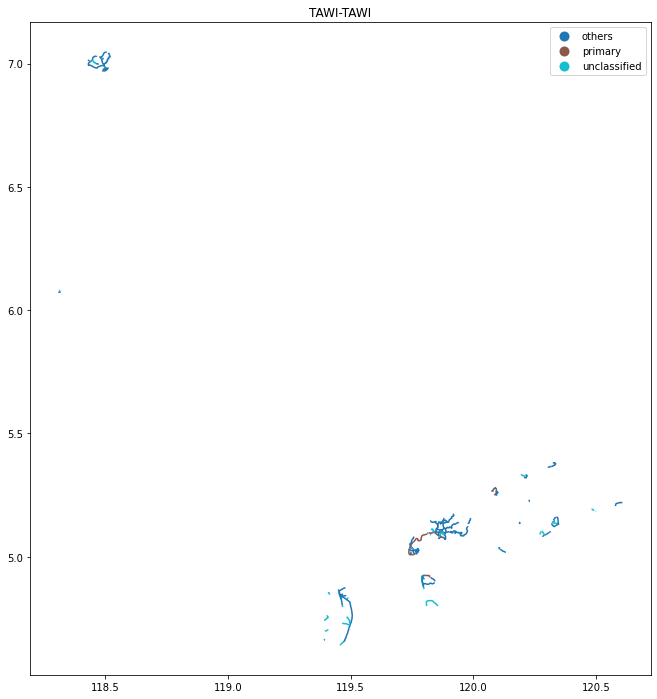

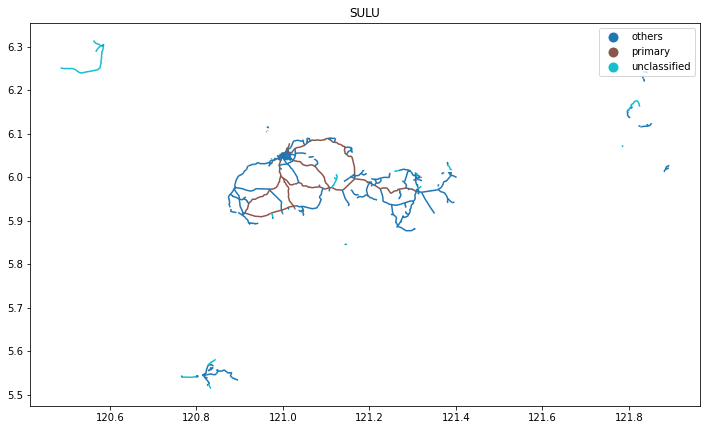

In [14]:
for province in roads_geodata['PROV'].unique():
    cond = roads_geodata['PROV']==province
    f, ax = plt.subplots(1, figsize=(12, 12))
    ax = roads_geodata[cond].plot(column="road_types", ax=ax, legend=True)
    plt.title(province)
    plt.show()